# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

## The Baseline

First, we load up the common elements to be used in the traditional and federated approaches. We start with the model.

In [1]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

# # Optional model for fun

# import torch.nn.functional as F

# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=0) # value 0 was chosen arbitrarily to quiet a warning. Penny'll start a fire.

#     def name(self):
#         return 'LeNet'

In [2]:
# load the data

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# create standard datasets using all of the MNIST data

data_path = './MNIST-data/raw'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

### Stacking a Deck

We need a way to "stack the deck" of examples that each worker sees. This method creates a dataset that is randomly sampled from a given dataset with the random sampling biased according to a dictionary of weights for each label.

In [3]:
from torch.utils.data import WeightedRandomSampler

def stacked_dset(dset, label_weights, N):
    """
    dset: dataset
    label_weights = {dog: 0.5, cat: 0.3, ...}
    N: size of stacked dset
    return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])

#     for label in test_dset.targets:
#         weights.append(label_weights[int(label)])
# TODO / MLW : how to speed this up - currently takes about a minute to train ten stacked training sets
    
    return WeightedRandomSampler(weights, N, replacement=False)

And this is where we get the dictionary of weights. For simplicity's sake, we just take a list of labels to be sampled "normally" and the rest are biased against. So, preserving 3s and skewing everything else by a factor of 0.9 shoud get a set of weights that results in a dataset that is slightly heavy on 3s compared to everything else. In an an extreme example, preserving only 3s, with a skew of 0, will produce weights that will yield a dataset of only 3s.

In [5]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

In [6]:
from torch.utils.data import DataLoader

batch_size = 64

# # create standard dataloaders using all of the MNIST data - this is for baseline purposes
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [7]:
from collections import Counter

_, ys = list(zip(*test_dloader))
print("Test: ", Counter(int(y) for y in torch.cat(ys)).most_common())

_, ys = list(zip(*train_dloader))
print("Train:", Counter(int(y) for y in torch.cat(ys)).most_common())

Test:  [(1, 1135), (2, 1032), (7, 1028), (3, 1010), (9, 1009), (4, 982), (0, 980), (8, 974), (6, 958), (5, 892)]
Train: [(1, 6742), (7, 6265), (3, 6131), (2, 5958), (9, 5949), (0, 5923), (6, 5918), (8, 5851), (4, 5842), (5, 5421)]


These plots show quickly that the sets are distributed fairly similarly.

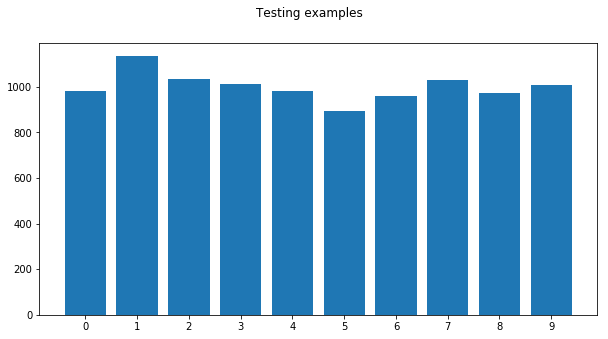

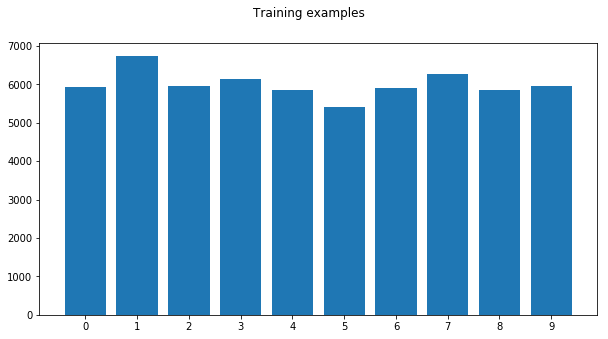

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Testing examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
H = ax.hist(test_dloader.dataset.targets, bins=range(11), histtype='bar', align='left', rwidth=0.8)

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Training examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
H = ax.hist(train_dloader.dataset.targets, bins=range(11), histtype='bar', align='left', rwidth=0.8)

Here we do the sampling to create our skewed datasets.

In [9]:
from tqdm import tqdm

# create stacked loaders for the workers

skew_bias = 0.5
loader_size = 8192
num_workers = 10

stacked_data_loaders = []

for label in tqdm(range(num_workers)):
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label], skew_bias), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

100%|██████████| 10/10 [01:52<00:00, 12.36s/it]


We should see the effect of the skew in a histogram of a skewed dataset.

In [10]:
_, ybatches = list(zip(*stacked_data_loaders[1]))
ys = torch.cat(ybatches)
ys = [int(y) for y in ys]
print(Counter(ys).most_common())

[(1, 1532), (2, 776), (3, 773), (7, 768), (0, 761), (6, 746), (4, 734), (8, 734), (9, 712), (5, 656)]


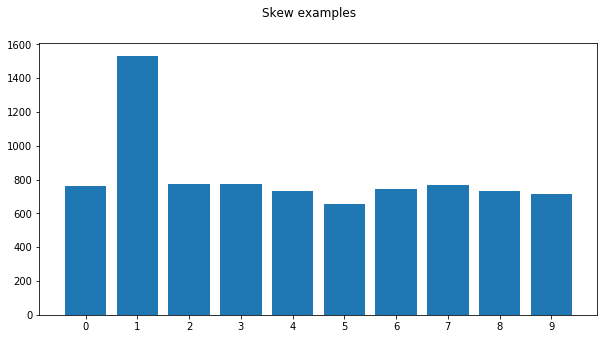

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Skew examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
H = ax.hist(ys, bins=range(11), histtype='bar', align='left', rwidth=0.8)

In [12]:
import federated

learning_rate = 5e-3
num_epochs = 1
num_rounds = 8

skewed_train_dsets = stacked_data_loaders

manager = federated.FederatedManager(
    skewed_train_dsets,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [13]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) per round.\n" )

for i in tqdm(range(num_rounds)):
    print("Beginning round", i+1)
    manager.round()
    print("Finished round", i+1, "with global loss: %.5f" % manager.manager_loss_history[-1], "\n")

  0%|          | 0/8 [00:00<?, ?it/s]

Training 8 round(s) with 10 worker(s) doing 1 epoch(s) per round.

Beginning round 1
	Worker: 6464 	epoch: 1 	batch: 0 	local loss: 2.3014
	Worker: 6464 	epoch: 1 	batch: 32 	local loss: 2.2944
	Worker: 6464 	epoch: 1 	batch: 64 	local loss: 2.2808
	Worker: 6464 	epoch: 1 	batch: 96 	local loss: 2.2488
	Worker: 6464 	epoch: 1 	batch: 128 	local loss: 2.2744 

	Worker: 3320 	epoch: 1 	batch: 0 	local loss: 2.2989
	Worker: 3320 	epoch: 1 	batch: 32 	local loss: 2.2854
	Worker: 3320 	epoch: 1 	batch: 64 	local loss: 2.2433
	Worker: 3320 	epoch: 1 	batch: 96 	local loss: 2.2759
	Worker: 3320 	epoch: 1 	batch: 128 	local loss: 2.2153 

	Worker: 0424 	epoch: 1 	batch: 0 	local loss: 2.2908
	Worker: 0424 	epoch: 1 	batch: 32 	local loss: 2.2789
	Worker: 0424 	epoch: 1 	batch: 64 	local loss: 2.2762
	Worker: 0424 	epoch: 1 	batch: 96 	local loss: 2.2763
	Worker: 0424 	epoch: 1 	batch: 128 	local loss: 2.2333 

	Worker: 8816 	epoch: 1 	batch: 0 	local loss: 2.3068
	Worker: 8816 	epoch: 1 	batch

 12%|█▎        | 1/8 [02:53<20:13, 173.30s/it]

Finished round 1 with global loss: 2.25508 

Beginning round 2
	Worker: 6464 	epoch: 1 	batch: 0 	local loss: 2.2455
	Worker: 6464 	epoch: 1 	batch: 32 	local loss: 2.2469
	Worker: 6464 	epoch: 1 	batch: 64 	local loss: 2.2226
	Worker: 6464 	epoch: 1 	batch: 96 	local loss: 2.2325
	Worker: 6464 	epoch: 1 	batch: 128 	local loss: 2.1387 

	Worker: 3320 	epoch: 1 	batch: 0 	local loss: 2.2528
	Worker: 3320 	epoch: 1 	batch: 32 	local loss: 2.2035
	Worker: 3320 	epoch: 1 	batch: 64 	local loss: 2.1694
	Worker: 3320 	epoch: 1 	batch: 96 	local loss: 2.1464
	Worker: 3320 	epoch: 1 	batch: 128 	local loss: 2.0914 

	Worker: 0424 	epoch: 1 	batch: 0 	local loss: 2.2660
	Worker: 0424 	epoch: 1 	batch: 32 	local loss: 2.2403
	Worker: 0424 	epoch: 1 	batch: 64 	local loss: 2.2510
	Worker: 0424 	epoch: 1 	batch: 96 	local loss: 2.2052
	Worker: 0424 	epoch: 1 	batch: 128 	local loss: 2.2072 

	Worker: 8816 	epoch: 1 	batch: 0 	local loss: 2.2413
	Worker: 8816 	epoch: 1 	batch: 32 	local loss: 2.25

 25%|██▌       | 2/8 [06:06<17:55, 179.21s/it]

Finished round 2 with global loss: 2.19709 

Beginning round 3
	Worker: 6464 	epoch: 1 	batch: 0 	local loss: 2.2101
	Worker: 6464 	epoch: 1 	batch: 32 	local loss: 2.1925
	Worker: 6464 	epoch: 1 	batch: 64 	local loss: 2.1478
	Worker: 6464 	epoch: 1 	batch: 96 	local loss: 2.1415
	Worker: 6464 	epoch: 1 	batch: 128 	local loss: 2.0798 

	Worker: 3320 	epoch: 1 	batch: 0 	local loss: 2.1533
	Worker: 3320 	epoch: 1 	batch: 32 	local loss: 2.1061
	Worker: 3320 	epoch: 1 	batch: 64 	local loss: 2.1268
	Worker: 3320 	epoch: 1 	batch: 96 	local loss: 2.0514
	Worker: 3320 	epoch: 1 	batch: 128 	local loss: 2.0274 

	Worker: 0424 	epoch: 1 	batch: 0 	local loss: 2.2034
	Worker: 0424 	epoch: 1 	batch: 32 	local loss: 2.1626
	Worker: 0424 	epoch: 1 	batch: 64 	local loss: 2.1413
	Worker: 0424 	epoch: 1 	batch: 96 	local loss: 2.1484
	Worker: 0424 	epoch: 1 	batch: 128 	local loss: 2.0892 

	Worker: 8816 	epoch: 1 	batch: 0 	local loss: 2.1789
	Worker: 8816 	epoch: 1 	batch: 32 	local loss: 2.18

 38%|███▊      | 3/8 [09:12<15:06, 181.32s/it]

Finished round 3 with global loss: 2.11571 

Beginning round 4
	Worker: 6464 	epoch: 1 	batch: 0 	local loss: 2.1388
	Worker: 6464 	epoch: 1 	batch: 32 	local loss: 2.0780
	Worker: 6464 	epoch: 1 	batch: 64 	local loss: 2.0227
	Worker: 6464 	epoch: 1 	batch: 96 	local loss: 1.9971
	Worker: 6464 	epoch: 1 	batch: 128 	local loss: 2.0481 

	Worker: 3320 	epoch: 1 	batch: 0 	local loss: 2.0767
	Worker: 3320 	epoch: 1 	batch: 32 	local loss: 2.0866
	Worker: 3320 	epoch: 1 	batch: 64 	local loss: 2.0286
	Worker: 3320 	epoch: 1 	batch: 96 	local loss: 2.0120
	Worker: 3320 	epoch: 1 	batch: 128 	local loss: 1.8452 

	Worker: 0424 	epoch: 1 	batch: 0 	local loss: 2.1107
	Worker: 0424 	epoch: 1 	batch: 32 	local loss: 2.0879
	Worker: 0424 	epoch: 1 	batch: 64 	local loss: 2.0175
	Worker: 0424 	epoch: 1 	batch: 96 	local loss: 1.9773
	Worker: 0424 	epoch: 1 	batch: 128 	local loss: 1.9963 

	Worker: 8816 	epoch: 1 	batch: 0 	local loss: 2.1325
	Worker: 8816 	epoch: 1 	batch: 32 	local loss: 2.03

 50%|█████     | 4/8 [12:41<12:38, 189.63s/it]

Finished round 4 with global loss: 1.99744 

Beginning round 5
	Worker: 6464 	epoch: 1 	batch: 0 	local loss: 2.0217
	Worker: 6464 	epoch: 1 	batch: 32 	local loss: 1.9243
	Worker: 6464 	epoch: 1 	batch: 64 	local loss: 1.9697
	Worker: 6464 	epoch: 1 	batch: 96 	local loss: 1.9560
	Worker: 6464 	epoch: 1 	batch: 128 	local loss: 1.8361 

	Worker: 3320 	epoch: 1 	batch: 0 	local loss: 2.0076
	Worker: 3320 	epoch: 1 	batch: 32 	local loss: 2.0006
	Worker: 3320 	epoch: 1 	batch: 64 	local loss: 1.8938
	Worker: 3320 	epoch: 1 	batch: 96 	local loss: 1.8321
	Worker: 3320 	epoch: 1 	batch: 128 	local loss: 1.8773 

	Worker: 0424 	epoch: 1 	batch: 0 	local loss: 2.0164
	Worker: 0424 	epoch: 1 	batch: 32 	local loss: 1.9745
	Worker: 0424 	epoch: 1 	batch: 64 	local loss: 1.9423
	Worker: 0424 	epoch: 1 	batch: 96 	local loss: 1.8289
	Worker: 0424 	epoch: 1 	batch: 128 	local loss: 1.8667 

	Worker: 8816 	epoch: 1 	batch: 0 	local loss: 1.9864
	Worker: 8816 	epoch: 1 	batch: 32 	local loss: 1.99

 62%|██████▎   | 5/8 [15:27<09:07, 182.57s/it]

Finished round 5 with global loss: 1.82994 

Beginning round 6
	Worker: 6464 	epoch: 1 	batch: 0 	local loss: 1.7563
	Worker: 6464 	epoch: 1 	batch: 32 	local loss: 1.7120
	Worker: 6464 	epoch: 1 	batch: 64 	local loss: 1.5714
	Worker: 6464 	epoch: 1 	batch: 96 	local loss: 1.6187
	Worker: 6464 	epoch: 1 	batch: 128 	local loss: 1.7099 

	Worker: 3320 	epoch: 1 	batch: 0 	local loss: 1.7697
	Worker: 3320 	epoch: 1 	batch: 32 	local loss: 1.6869
	Worker: 3320 	epoch: 1 	batch: 64 	local loss: 1.7187
	Worker: 3320 	epoch: 1 	batch: 96 	local loss: 1.5563
	Worker: 3320 	epoch: 1 	batch: 128 	local loss: 1.5771 

	Worker: 0424 	epoch: 1 	batch: 0 	local loss: 1.7894
	Worker: 0424 	epoch: 1 	batch: 32 	local loss: 1.7856
	Worker: 0424 	epoch: 1 	batch: 64 	local loss: 1.7641
	Worker: 0424 	epoch: 1 	batch: 96 	local loss: 1.6520
	Worker: 0424 	epoch: 1 	batch: 128 	local loss: 1.6680 

	Worker: 8816 	epoch: 1 	batch: 0 	local loss: 1.8394
	Worker: 8816 	epoch: 1 	batch: 32 	local loss: 1.75

 75%|███████▌  | 6/8 [17:48<05:39, 169.94s/it]

Finished round 6 with global loss: 1.61949 

Beginning round 7
	Worker: 6464 	epoch: 1 	batch: 0 	local loss: 1.6170
	Worker: 6464 	epoch: 1 	batch: 32 	local loss: 1.6254
	Worker: 6464 	epoch: 1 	batch: 64 	local loss: 1.5677
	Worker: 6464 	epoch: 1 	batch: 96 	local loss: 1.4462
	Worker: 6464 	epoch: 1 	batch: 128 	local loss: 1.4153 

	Worker: 3320 	epoch: 1 	batch: 0 	local loss: 1.6032
	Worker: 3320 	epoch: 1 	batch: 32 	local loss: 1.4712
	Worker: 3320 	epoch: 1 	batch: 64 	local loss: 1.4698
	Worker: 3320 	epoch: 1 	batch: 96 	local loss: 1.3960
	Worker: 3320 	epoch: 1 	batch: 128 	local loss: 1.3492 

	Worker: 0424 	epoch: 1 	batch: 0 	local loss: 1.6896
	Worker: 0424 	epoch: 1 	batch: 32 	local loss: 1.5483
	Worker: 0424 	epoch: 1 	batch: 64 	local loss: 1.4105
	Worker: 0424 	epoch: 1 	batch: 96 	local loss: 1.4344
	Worker: 0424 	epoch: 1 	batch: 128 	local loss: 1.4402 

	Worker: 8816 	epoch: 1 	batch: 0 	local loss: 1.7237
	Worker: 8816 	epoch: 1 	batch: 32 	local loss: 1.57

 88%|████████▊ | 7/8 [20:20<02:44, 164.55s/it]

Finished round 7 with global loss: 1.39970 

Beginning round 8
	Worker: 6464 	epoch: 1 	batch: 0 	local loss: 1.4187
	Worker: 6464 	epoch: 1 	batch: 32 	local loss: 1.2878
	Worker: 6464 	epoch: 1 	batch: 64 	local loss: 1.1871
	Worker: 6464 	epoch: 1 	batch: 96 	local loss: 1.1463
	Worker: 6464 	epoch: 1 	batch: 128 	local loss: 1.2396 

	Worker: 3320 	epoch: 1 	batch: 0 	local loss: 1.2897
	Worker: 3320 	epoch: 1 	batch: 32 	local loss: 1.2455
	Worker: 3320 	epoch: 1 	batch: 64 	local loss: 1.0637
	Worker: 3320 	epoch: 1 	batch: 96 	local loss: 1.1847
	Worker: 3320 	epoch: 1 	batch: 128 	local loss: 1.1801 

	Worker: 0424 	epoch: 1 	batch: 0 	local loss: 1.4542
	Worker: 0424 	epoch: 1 	batch: 32 	local loss: 1.3855
	Worker: 0424 	epoch: 1 	batch: 64 	local loss: 1.2780
	Worker: 0424 	epoch: 1 	batch: 96 	local loss: 1.2780
	Worker: 0424 	epoch: 1 	batch: 128 	local loss: 1.1417 

	Worker: 8816 	epoch: 1 	batch: 0 	local loss: 1.3988
	Worker: 8816 	epoch: 1 	batch: 32 	local loss: 1.29

100%|██████████| 8/8 [22:42<00:00, 157.91s/it]

Finished round 8 with global loss: 1.20478 



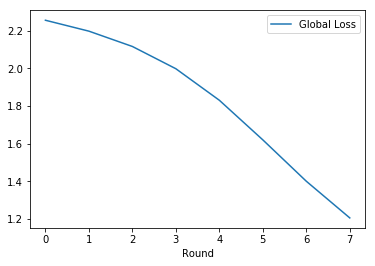

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="Global Loss")
ax.set_xlabel("Round");
ax.legend();

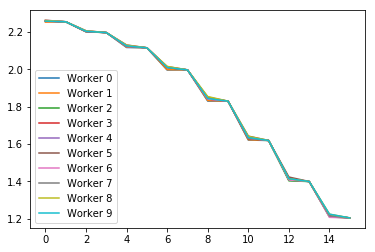

In [15]:
fig, ax = plt.subplots()

for i in range(len(manager.worker_loss_histories)):
    lbl = "Worker " + str(i)
    ax.plot(manager.worker_loss_histories[i], label=lbl)
    ax.legend();

Outline:
- Set up a model and data
- train the model N epochs without federation note baseline performance (and size of the data that would have to have been transferedd?) 
    - is this model trained on the full dataset? Or do we sample randomly across it to have the same number of examples?
- Federate without skew or mild skew, compare performance with baseline (and size of model compared to data)
- Federate with only a few numbers skewed (like, lacking only 7s or something) 
- Federate with heavy skew
- Federate with complete skew

Ideas:
- plot performance on a given numeral for the main model next to that of a worker skewed against that numeral. Let both run without federation or run a few epochs before federation. Show this as a baseline
- histogram of numerals? More for curiosity, but shows spread of data that we might want to reflect in the baseline training.
- post 1: what's the accuracy loss for federation compared to baseline direct training?
- post 2: weird side stats
    - skew vs. accuracy
        - plot - x-axis = skew, y-axis = accuracy
    - run all to convergence, compare how long to reach comparable accuracy?
        - time or epochs necessary to reach comparable accuracy between federated and standard approach
        - time or epochs necessary to reach comparable accuracy by skew
    - 

Questions:
- Why does the time spent by a worker on any given epoch all happen _before_ the batches start rolling in? What's happening there? Am I just spinning my wheels on something?
    - TODO: try this from a regular python file. The notebook may be buffering up those print statements in the batches
- Why does random selection of the skewed datasets take so long? Is it because they're without replacement?
- Why do all the workers and epochs always happen in order? Wouldn't my laptop parallelize them across cores? Is that too much to ask from an interpreter? Is the interpreter smarter than I am and actually is parallelizing them and the smartest way in to do them in order?
- why use ten workers? Why not fewer?